# Notebook for dataset variable plotting

## Base imports

In [1]:
import os
from copy import deepcopy
from itertools import product
import numpy as np
from scipy.stats import wasserstein_distance
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
import mplhep as hep
import seaborn as sns
from ringer.constants import HOME_PATH, STEP_PREFIX
from ringer.utils import get_logger
from ringer.data import get_electron_label, get_jet_label
from ringer.regions import get_et_eta_regions
from ringer.constants import VAR_INFOS_DTYPES, DEFAULT_FIGSIZE, DEFAULT_DPI
plt.style.use(hep.style.ATLAS)
plt.rc('legend',fontsize='large')
plt.rc('axes',labelsize='x-large')
plt.rc('text',usetex='false')
plt.rc('xtick', labelsize='large')
plt.rc('figure', figsize=DEFAULT_FIGSIZE)
plt.rc('figure', dpi=DEFAULT_DPI)

ET_BINS = [15.0,20.0,30.0,40.0,50.0,100.0,np.inf]
ETA_BINS = [0,0.8,1.37,1.54,2.37,2.5]
# ET_ETA_REGIONS = get_et_eta_regions(ET_BINS, ETA_BINS)
%matplotlib inline

### Functions

In [2]:
def save_hists_df(hists_dict, output_dir, var, name):
    for hist_name, org_hist_df in hists_dict.items():
        source_name = hist_name.replace(' ', '_').lower()
        filepath = os.path.join(output_dir, f'{var}_{source_name}_{name}_hist.csv')
        org_hist_df.to_csv(filepath)
    return 0

In [3]:
def get_hist_df(hist, bins):
    hist_df_cols = ['bin_start', 'bin_end', 'hist']
    hist_df = pd.DataFrame(np.column_stack((bins[:-1], bins[1:], hist)), columns=hist_df_cols)
    return hist_df

In [4]:
def get_var_info(var: str):
    return VAR_INFOS.loc[VAR_INFOS['name']==var].iloc[0].to_dict()

In [5]:
def add_regions(df, et_bins, eta_bins, inplace=False, eta_tol=1e-6, step='l2calo'):

    if not inplace:
        df=df.copy()

    et_info = get_var_info('et')
    eta_info = get_var_info('eta')
    n_ets = len(et_bins)-1
    n_etas = len(eta_bins)-1

    et_labels=list()
    for i, interval in enumerate(zip(et_bins[:-1], et_bins[1:])):
        left, right = interval
        if (i<n_ets-1) or (right == np.inf):
            et_labels.append(f'[{left}, {right})')
        else:   #Last interval
            et_labels.append(f'[{left}, {right}]')
    et_intervals = pd.IntervalIndex.from_arrays(left=et_bins[:-1], right=et_bins[1:], closed='left')
    df[et_info['label']] =  pd.cut(df[et_info[step]], bins=et_bins, labels=et_labels, ordered=True)
    
    eta_labels=list()
    for i, interval in enumerate(zip(eta_bins[:-1], eta_bins[1:])):
        left, right = interval
        if i<n_etas-1 or (right == np.inf):
            eta_labels.append(f'[{left}, {right})')
        else:   #Last interval
            eta_labels.append(f'[{left}, {right}]')
    eta_bins = deepcopy(eta_bins)
    eta_bins[-1] += eta_tol
    eta_intervals = pd.IntervalIndex.from_arrays(left=eta_bins[:-1], right=eta_bins[1:], closed='left')
    df['|' + eta_info['label'] + '|'] =  pd.cut(df[eta_info[step]].abs(), bins=eta_bins, labels=eta_labels, ordered=True)
    
    return df

In [6]:
def histplot(data, x, xlabel:str=None, xrange=None, xbins=None, write_legend=True, xlim=None, ylim=None,
             title=None, orientation='vertical', ax=None, write_labels=True, density:bool=True,
             plot_scale='log', despine=True, write_samples=True, xlabel_loc='right'):
    
    if write_labels:
        xlabel = x if xlabel is None else xlabel
        ylabel = 'Density' if density else 'Counts'
    else:
        xlabel = None
        ylabel = None
    
    ax = plt.gca() if ax is None else ax
    hists = dict()
    patches = dict()
    if type(xbins) is not dict:
        xbins = dict.fromkeys(data.keys(), xbins)
    if type(xrange) is not dict:
        xrange = dict.fromkeys(data.keys(), xrange)
    
    for data_name, data_df in data.items():
        n_samples = '{:.3e}'.format(len(data_df))
        if write_labels:
            label = f'{data_name} {n_samples} samples'
        else:
            label = f'{data_name}'
        hist, bins, patch = ax.hist(data_df[x], bins=xbins[data_name], label=label,
                                     density=density, range=xrange[data_name], histtype='step', orientation=orientation)
        hists[data_name] = (hist, bins)
        patches[data_name] = patch
    
    ax.set(xlim=xlim, ylabel=ylabel, yscale=plot_scale, ylim=ylim)
    ax.set_xlabel(xlabel, loc=xlabel_loc)
    if write_legend:
        ax.legend()
    if title is not None:
        ax.set_title(title, fontsize='xx-large')
    if despine:
        if type(despine) is bool:
            sns.despine(ax=ax)
        else:
            sns.despine(ax=ax, **despine)
    
    return ax, hists, patches

In [7]:
def get_facet_matrix(nrows=1, ncols=1, sharex=True, sharey=True, **kwargs):
    fig, axes = plt.subplots(nrows, ncols, **kwargs)
    if ncols != 1 and sharey:
        for row in range(nrows):
            ax_0i = axes[row,0]
            for col in range(1, ncols):
                ax_0i.get_shared_y_axes().join(ax_0i, axes[row, col])
    
    if nrows != 1 and sharex:
        for col in range(ncols):
            ax_i0 = axes[0,col]
            for row in range(1, nrows):
                ax_i0.get_shared_x_axes().join(ax_i0, axes[row, col])
    return fig, axes

def facetplot(data, x, col_var, row_var, xlabel:str=None, xrange=None, xbins=None, xlim=None, 
              col_var_label:str=None, row_var_label:str=None, plot_scale='log', title:str=None, 
              figsize=(9,6.6), dpi=72, logger='plot_log', col_var_order=None, row_var_order=None, legend_loc=None):
    
    logger = get_logger(logger)

    col_var_label = '' if col_var_label is None else col_var_label
    row_var_label = '' if row_var_label is None else row_var_label
    all_categories = dict(col=list(), row=list())
    for data_name, data_df in data.items():
        data_col_var = data_df[col_var].unique()
        data_row_var = data_df[row_var].unique()
        to_add_col = data_col_var[~data_col_var.isin(all_categories['col'])].to_list()
        to_add_row = data_row_var[~data_row_var.isin(all_categories['row'])].to_list()                  
        all_categories['col'] += to_add_col
        all_categories['row'] += to_add_row
    
    if col_var_order is not None:
        order_dict = {value: i for i, value in enumerate(col_var_order)}
        all_categories['col'].sort(key=lambda key: order_dict[key])
    
    if row_var_order is not None:
        order_dict = {value: i for i, value in enumerate(row_var_order)}
        all_categories['row'].sort(key=lambda key: order_dict[key])
    
    n_cat_col = len(all_categories['col'])
    n_cat_row = len(all_categories['row'])
    fig, axes = get_facet_matrix(n_cat_row,n_cat_col, sharex=True, sharey=False, figsize=figsize, dpi=dpi)                       
    hists = np.empty((n_cat_row,n_cat_col), dtype=object)
    patches = np.empty((n_cat_row,n_cat_col), dtype=object)
    upper_ylim = np.empty((n_cat_row,n_cat_col), dtype=float)
    lower_ylim = np.empty((n_cat_row,n_cat_col), dtype=float)
    upper_xlim = np.empty((n_cat_row,n_cat_col), dtype=float)
    lower_xlim = np.empty((n_cat_row,n_cat_col), dtype=float)
    for irow, icol in product(range(n_cat_row), range(n_cat_col)):
        ax = axes[irow, icol]
        cat_col = all_categories['col'][icol]
        cat_row = all_categories['row'][irow]
        logger.info(f'At row {cat_row} and col {cat_col}')
        bin_data = dict()
        for data_name, data_df in data.items():
            in_x = data_df[col_var] == cat_col
            in_y = data_df[row_var] == cat_row
            bin_df = data_df.loc[in_x&in_y, [x]]
            if bin_df.empty:
                logger.warning(f'{data_name} at {cat_row},{cat_col} is empty')
            bin_data[data_name] = bin_df
        
        _, hists[irow, icol], patches[irow, icol] = histplot(bin_data, x, xrange=xrange, xbins=xbins, xlim=xlim, 
            ax=ax, include_legend=False, despine=True, plot_scale=plot_scale, write_labels=False, write_samples=False)
        lower_ylim[irow, icol], upper_ylim[irow, icol] = ax.get_ylim()
        lower_xlim[irow, icol], upper_xlim[irow, icol] = ax.get_xlim()
        
        text_kwargs = dict(
            fontsize='large'
        )
        if icol == 0:    #First col
            if row_var_label is None:
                ax.set_ylabel(f'{cat_row}', loc='bottom',**text_kwargs)
            else:
                ax.set_ylabel(f'{row_var_label}: {cat_row}', loc='bottom', **text_kwargs)

        if irow == n_cat_row-1:    #Last row
            if col_var_label is None:
                ax.set_xlabel(f'{cat_col}', loc='left', **text_kwargs)
            else:
                ax.set_xlabel(f'{col_var_label}: {cat_col}', loc='left', **text_kwargs)
    
    # Making all y axis limits equal
    row_upper_lim = upper_ylim.max(axis=1)
    row_lower_lim = lower_ylim.min(axis=1)
    for irow, upper, lower in zip(range(n_cat_row), row_upper_lim, row_lower_lim):
        for icol in range(n_cat_col):
            axes[irow, icol].set_ylim(lower, upper)
    
    # Making all x axis limits equal
    col_upper_lim = upper_xlim.max(axis=0)
    col_lower_lim = lower_xlim.min(axis=0)
    for icol, upper, lower in zip(range(n_cat_col), col_upper_lim, col_lower_lim):
        for irow in range(n_cat_row):
            axes[irow, icol].set_xlim(lower, upper)

    # Removing ticks from axes outside of first column and last row
    # Done at the end because changing the axis lims resets the ticks
    for irow, icol in product(range(n_cat_row), range(n_cat_col)):
        ax = axes[irow, icol]
        if icol == 0: #First col
            for ticklabel in ax.get_yticklabels():
                ticklabel.set_fontsize('small')
        else:
            ax.set_yticklabels([])

        if irow == n_cat_row-1:    #Last row
            for ticklabel in ax.get_xticklabels():
                ticklabel.set_fontsize('small')
        else:
            ax.set_xticklabels([])
    
    if legend_loc is not None:
        axes[0, n_cat_col-1].legend(bbox_to_anchor=legend_loc)
    if title is not None:
        fig.suptitle(title, fontsize='xx-large', ha='left')
    return fig, axes, hists, patches

In [8]:
def jointplot(data:pd.DataFrame, x:str, y:str, x_label:str=None, y_label:str=None, data_label:str=None,
              x_bins=None, y_bins=None, x_range=None, y_range=None, xlim=None, ylim=None, write_legend=True,
              cmap='icefire_r', norm:str='log', figsize=None, marginal_ticks=True, sub_ax_kwargs:dict=None, 
              step=None, vmin=None, vmax=None, shared_cmap:bool=False):
    x_label = x if x_label is None else x_label
    y_label = y if y_label is None else y_label
    data_label = '' if data_label is None else data_label
    
    if norm == 'log':
        plot_scale = 'log'
        norm = mpl.colors.LogNorm(vmin, vmax)
    else:
        raise NotImplementedError
    
    jgrid = sns.JointGrid(marginal_ticks=marginal_ticks)
    jgrid.ax_marg_x.set(yscale=plot_scale, ylabel='Density')
    jgrid.ax_marg_y.set(xscale=plot_scale, xlabel='Density')
    x_hists, x_bins, x_patches= jgrid.ax_marg_x.hist(data[x], bins=x_bins, 
                density=True, range=x_range, histtype='step', color='k')
    y_hists, y_bins, y_patches = jgrid.ax_marg_y.hist(data[y], bins=y_bins,
                density=True, range=y_range, orientation='horizontal', histtype='step', color='k')
    joint = jgrid.ax_joint.hist2d(data[x], data[y], bins=[x_bins, y_bins], range=[x_range, y_range],
                cmin=1e-12, cmap=cmap, density=True, 
                norm=norm)
    # Setting the colorbar to the right, it orignaly stays between the join ax and the marg_y ax
    cbar_ax = plt.colorbar(joint[-1], ax=jgrid.ax_joint, use_gridspec=True, fraction=0.1, label='Density')
    plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)
    # get the current positions of the joint ax and the ax for the marginal x
    pos_joint_ax = jgrid.ax_joint.get_position()
    pos_marg_x_ax = jgrid.ax_marg_x.get_position()
    pos_marg_y_ax = jgrid.ax_marg_y.get_position()
    # reposition the joint ax so it has the same width as the marginal x ax
    jgrid.ax_joint.set_position([pos_joint_ax.x0, pos_joint_ax.y0, pos_marg_x_ax.width, pos_joint_ax.height])
    # reposition the colorbar using new x positions and y positions of the joint ax
    jgrid.figure.axes[-1].set_position([.83, pos_joint_ax.y0, .07, pos_joint_ax.height])
    
    jgrid.ax_joint.set(ylim=ylim, xlim=xlim, xlabel=x_label, ylabel=y_label)
    if step is None:
        jgrid.figure.suptitle(f'{y_label} x {x_label} distribution {data_label}', fontsize='xx-large')
    else:
        jgrid.figure.suptitle(f'{step} {y_label} x {x_label} distribution {data_label}', fontsize='xx-large')
    if figsize is not None:
        jgrid.figure.set_figwidth(figsize[0])
        jgrid.figure.set_figheight(figsize[1])
    
    if write_legend:
        jgrid.figure.text(0.7, 0.9, f'Samples:\n{len(data):.3e}', fontsize='large',
                    va='top', wrap=True)
    return_dict = dict(marg_x=[x_hists, x_bins, x_patches], 
        marg_y=[y_hists, y_bins, y_patches], joint=joint)
    
    if sub_ax_kwargs is not None:
        sub_ax = jgrid.figure.add_axes(sub_ax_kwargs.pop('pos'))
        sub_ax.hist2d(data[x], data[y], bins=[x_bins, y_bins], range=[x_range, y_range],
                        cmin=1e-12, cmap=cmap, density=True, norm=norm)
        sub_ax.set(**sub_ax_kwargs)
        return_dict['sub_ax'] = sub_ax
    
    return jgrid, return_dict

In [9]:
def wasserstein_versus_boosted(data, var, var_range=None):
    res = dict()
    boosted_name = 'MC16 Boosted el'
    boosted_df = data[boosted_name]
    for data_name, data_df in data.items():
        if data_name == boosted_name:
            continue
        if var_range is None:
            u = data_df[var]
            v = boosted_df[var]
        else:
            u = data_df.loc[data_df[var].between(*var_range), var]
            v = boosted_df.loc[boosted_df[var].between(*var_range), var]
        res[data_name] = wasserstein_distance(u,v)
    return res

In [10]:
def get_hist2d_log_norms(data, x, y, var_bins, var_ranges, step):
    fig, ax = plt.subplots(1,1)
    vmin = np.inf
    vmax = -np.inf
    x_info = get_var_info(x)
    y_info = get_var_info(y)
    for data_name, data_df in data.items():
        norm = mpl.colors.LogNorm()
        xbins = var_bins[data_name][x]
        ybins = var_bins[data_name][y]
        xrange = var_ranges[data_name][x]
        yrange = var_ranges[data_name][y]
        ax.hist2d(data_df[x_info[step]], data_df[y_info[step]], 
            bins=[xbins, ybins], range=[xrange, yrange],
            cmin=1e-12, density=True, norm=norm)
        if vmin > norm.vmin:
            vmin = norm.vmin  
        if vmax < norm.vmax:
            vmax=norm.vmax
    plt.close(fig)
    return vmin, vmax

## Loading data

In [11]:
plot_cols = list()
plot_logger = get_logger('plot_log', file=False)
step = 'offline'
basepath = os.path.join('..', '..')
output_dir = os.path.join(basepath, 'analysis', 'vars_distributions')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
datapath = os.path.join(basepath, 'data')
VAR_INFOS = pd.read_csv(os.path.join(datapath, 'var_infos.csv'), index_col=0, dtype=VAR_INFOS_DTYPES)
collision_path = os.path.join(datapath, 'ided_data17_13TeV.AllPeriods.sgn.probes_lhvloose_EGAM1.bkg.vprobes_vlhvloose_EGAM7.GRL_v97.25bins.parquet')
#                              'ided_data17_13TeV.AllPeriods.sgn.probes_lhvloose_EGAM1.bkg.vprobes_vlhvloose_EGAM7.GRL_v97.25bins.parquet_et4_eta4.parquet')
boosted_path = os.path.join(datapath, 'ided_mc16_13TeV.302236_309995_341330.sgn.boosted_probes.WZ_llqq_plus_radion_ZZ_llqq_plus_ggH3000.merge.25bins.v2.parquet')

load_cols = VAR_INFOS.loc[(VAR_INFOS['type'] == 'shower_shape') & (VAR_INFOS['l2calo'].isnull()), step].to_list()
load_cols += VAR_INFOS.loc[VAR_INFOS['name'].isin(['et', 'eta', 'mu']), step].to_list()
et_info = get_var_info('et')
# load_cols += VAR_INFOS.loc[VAR_INFOS['name'].isin(['ehad1', 'e2tsts1']), 'l2calo'].to_list()
print(load_cols)
VAR_INFOS

['el_rhad', 'el_rhad1', 'el_rphi', 'el_et', 'el_eta', 'avgmu']


,name,label,type,lower_lim,upper_lim,l2calo,offline,TaP,description
0,et,$E_T$,var,0.0,inf,trig_L2_cl_et,el_et,NaN,transverse particle energy on the calorimeter
1,eta,$\eta$,var,-2.5,2.5,trig_L2_cl_eta,el_eta,NaN,pseudorapidity
2,reta,$R_{\eta}$,shower_shape,0.0,1.0,trig_L2_cl_reta,el_reta,NaN,Ratio of the energy in 3x7 cells over the ener...
3,eratio,$E_{ratio}$,shower_shape,0.0,1.0,trig_L2_cl_eratio,el_eratio,NaN,Ratio of the energy difference between the max...
4,f1,$f_1$,shower_shape,0.0,1.0,trig_L2_cl_f1,el_f1,NaN,Ratio of the energy in the first layer to the ...
5,ehad1,$E_{had1}$,unidentified,-inf,inf,trig_L2_cl_ehad1,el_ehad1,NaN,unidentified
6,f3,$f_3$,shower_shape,0.0,1.0,trig_L2_cl_f3,el_f3,NaN,Ratio of the energy in the third layer to the ...
7,wstot,$\omega_{stot}$,shower_shape,0.0,inf,trig_L2_cl_wstot,el_wstot,NaN,Shower width er > 150 GeV only on EM1
8,weta2,$\omega_{\eta 2}$,shower_shape,0.0,inf,trig_L2_cl_weta2,el_weta2,NaN,Lateral shower width on EM2
9,e2tsts1,e2tsts1,unidentified,-inf,inf,trig_L2_cl_e2tsts1,el_e2tsts1,NaN,unidentified


In [12]:
boosted_data = pd.read_parquet(boosted_path, columns=load_cols + ['el_TaP_deltaR'])
boosted_data[et_info[step]] = boosted_data[et_info[step]]/1000
add_regions(boosted_data, ET_BINS, ETA_BINS, inplace=True, step=step)
boosted_data['source'] = 'MC16 Boosted el'
boosted_data['source'] = boosted_data['source'].astype('category')
boosted_data.tail()

,el_rhad,el_rhad1,el_rphi,el_et,el_eta,avgmu,el_TaP_deltaR,$E_T$,|$\eta$|,source
78909,0.000759,0.001316,0.948161,122.258362,-2.452464,27.50,0.623412,"[100.0, inf)","[2.37, 2.5]",MC16 Boosted el
78910,0.000289,0.000644,0.950956,182.585251,2.413724,28.49,0.376413,"[100.0, inf)","[2.37, 2.5]",MC16 Boosted el
78911,-0.002085,-0.000811,0.950298,208.517181,2.443757,40.50,0.310608,"[100.0, inf)","[2.37, 2.5]",MC16 Boosted el
78912,0.001961,0.001739,0.957002,339.877350,-2.120885,25.50,0.233797,"[100.0, inf)","[1.54, 2.37)",MC16 Boosted el
78913,0.000985,0.000550,0.945250,462.668274,-2.354597,25.50,0.233797,"[100.0, inf)","[1.54, 2.37)",MC16 Boosted el


In [13]:
start_time = datetime.now()
print(f'Start: {start_time}')
add_cols = ['target', 'el_lhmedium', 'el_lhvloose']
collision_data = pd.read_parquet(collision_path, columns=load_cols + add_cols)
read_time = datetime.now()
print(f'Time to read data {read_time-start_time}')
print(collision_data.shape)
jet_label = get_jet_label(collision_data, 'el_lhvloose')
el_label = get_electron_label(collision_data, 'el_lhmedium')
print(f'There are {jet_label.sum()} jets and {el_label.sum()} electrons')
label_time = datetime.now()
print(f'Time to labeling {label_time-read_time}')
print(f'Do electrons and jet have intersections? {(jet_label & el_label).any()}')
collision_data.drop(add_cols, axis=1, inplace=True)
el_data = collision_data.loc[el_label]
jet_data = collision_data.loc[jet_label]
del collision_data
#Converting MeV to GeV
el_data[et_info[step]] = el_data[et_info[step]]/1000
jet_data[et_info[step]] = jet_data[et_info[step]]/1000
el_data['source'] = 'Data17 Zee el'
el_data['source'] = el_data['source'].astype('category')
jet_data['source'] = 'Data17 Zee jet'
jet_data['source'] = jet_data['source'].astype('category')
drop_time = datetime.now()
print(f'Time to drop {drop_time-label_time}')
add_regions(el_data, ET_BINS, ETA_BINS, inplace=True, step=step)
add_regions(jet_data, ET_BINS, ETA_BINS, inplace=True, step=step)
end_time = datetime.now()
print(f'Time to add regions {end_time-drop_time}')
el_data.head()

Start: 2022-10-05 10:14:00.849092
Time to read data 0:00:46.786552
(43311283, 9)
There are 10906928 jets and 28955057 electrons
Time to labeling 0:00:00.183220
Do electrons and jet have intersections? False
Time to drop 0:00:02.109544
Time to add regions 0:00:01.018089


,el_rhad,el_rhad1,el_rphi,el_et,el_eta,avgmu,source,$E_T$,|$\eta$|
0,-0.014604,-0.010184,0.954679,19.993929,0.124495,44.700001,Data17 Zee el,"[15.0, 20.0)","[0, 0.8)"
1,0.001482,0.001126,0.709704,19.251659,0.279985,44.700001,Data17 Zee el,"[15.0, 20.0)","[0, 0.8)"
2,-0.016014,-0.007992,0.825018,16.419237,-0.269660,44.700001,Data17 Zee el,"[15.0, 20.0)","[0, 0.8)"
3,0.008715,0.008617,1.005868,17.731924,0.572261,44.630001,Data17 Zee el,"[15.0, 20.0)","[0, 0.8)"
4,0.034444,0.035376,0.959343,15.906787,-0.693648,44.580002,Data17 Zee el,"[15.0, 20.0)","[0, 0.8)"


In [14]:
data = {
    'MC16 Boosted el': boosted_data,
    'Data17 Zee el': el_data,
    'Data17 Zee jet': jet_data
}

## 1D Hist plots

2022-10-05 10:32:17,359 - Computing distances
2022-10-05 10:32:17,360 - Finished distances


offline_rhad1_free_with_zoom_range_log_scale_hist1d.png


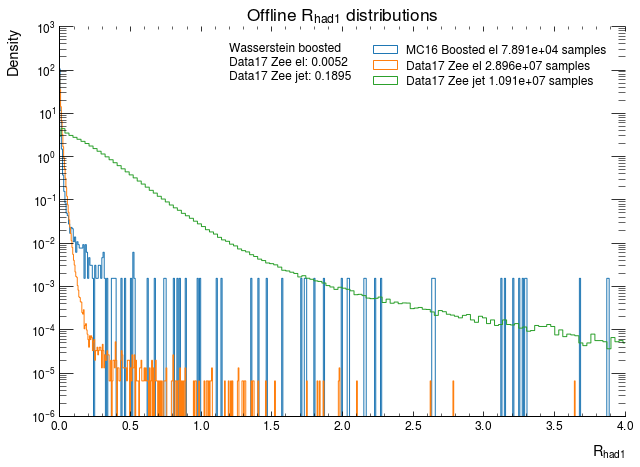

In [35]:
range_type = 'free_with_zoom'
var='rhad1'
plot_scale = 'log'
sub_ax = False
bins = 200
var_info = get_var_info(var)
if range_type == 'free':
    xrange = None
elif range_type == 'limited':
    if (var_info['lower_lim'] == -np.inf) or (var_info['upper_lim'] == np.inf):
        xrange = None
    else:
        xrange = (var_info['lower_lim'], var_info['upper_lim'])
elif range_type == 'boosted':
    xrange = (boosted_data[var_info[step]].min(), boosted_data[var_info[step]].max())
elif range_type.startswith('data_driven'):
    max_val = -np.inf
    min_val = np.inf
    upper_lim = 10
    lower_lim = -10
    for data_df in data.values():
        val = data_df.loc[data_df[var_info[step]] < upper_lim, var_info[step]].max()
        if max_val < val:
            max_val = val
    for data_df in data.values():
        val = data_df.loc[data_df[var_info[step]] > lower_lim, var_info[step]].min()
        if min_val > val:
            min_val = val
    xrange = (min_val, max_val)
else:   #Custom
    xrange=None
if xrange is not None:
    for data_name, data_df in data.items():
        print(f'{data_name} higher than max {(data_df[var_info[step]] > xrange[1]).sum()}')
    for data_name, data_df in data.items():
        print(f'{data_name} lower than min {(data_df[var_info[step]] < xrange[0]).sum()}')
title = f'{step.capitalize()} {var_info["label"]} distributions'
fig, ax = plt.subplots(1,1, figsize=(9,6.6), dpi=72)
ax, hist, patches = histplot(data, var_info[step], xlabel=var_info['label'], xrange=xrange,
                          xbins=4*bins, write_legend=True, xlim=(0,4),xlabel_loc='right', density=True,
                          title=title, ax=ax, plot_scale=plot_scale, despine=True)
plot_logger.info('Computing distances')
# distances = wasserstein_versus_boosted(data, var_info[step], var_range=xrange)
box_text = '\n'.join(['Wasserstein boosted'] + [f'{name}: {dist:.4f}' for name, dist in distances.items()])
ax.text(0.3,0.87, box_text, fontsize='large', wrap=True, transform=ax.transAxes, 
    bbox=dict(boxstyle='round', facecolor='white', edgecolor='white', alpha=0))
plot_logger.info('Finished distances')
if sub_ax:
    sub_ax_pos = [0.4, 0.4, 0.5, 0.4]
    sub_ax = fig.add_axes(sub_ax_pos)
    sub_ax, hist, patches = histplot(data, var_info[step], xlabel=None, xrange=xrange, 
                            xbins=bins, write_legend=False, xlim=(0,4), xlabel_loc='right',
                            title=None, ax=sub_ax, plot_scale=plot_scale, despine=True, write_labels=False)
fig.tight_layout()
filename = f'{step}_{var_info["name"]}_{range_type}_range_{plot_scale}_scale_hist1d.png'
print(filename)
fig.savefig(os.path.join(output_dir, filename), transparent=False, facecolor='white')

In [26]:
data_name = 'Data17 Zee el'
var_hist_df = get_hist_df(*hist[data_name])
var_hist_df

,bin_start,bin_end,hist
0,-636.070251,-633.134399,1.0
1,-633.134399,-630.198547,0.0
2,-630.198547,-627.262695,0.0
3,-627.262695,-624.326843,0.0
4,-624.326843,-621.390991,0.0
...,...,...,...
495,817.177307,820.113159,0.0
496,820.113159,823.049011,0.0
497,823.049011,825.984863,0.0
498,825.984863,828.920715,0.0


2022-09-23 21:51:29,980 - At row [0, 0.8) and col [15.0, 20.0)
2022-09-23 21:51:30,054 - At row [0, 0.8) and col [20.0, 30.0)
2022-09-23 21:51:30,189 - At row [0, 0.8) and col [30.0, 40.0)
2022-09-23 21:51:30,451 - At row [0, 0.8) and col [40.0, 50.0)
2022-09-23 21:51:30,687 - At row [0, 0.8) and col [50.0, 100.0)
2022-09-23 21:51:30,818 - At row [0, 0.8) and col [100.0, inf)
2022-09-23 21:51:31,015 - At row [0.8, 1.37) and col [15.0, 20.0)
2022-09-23 21:51:31,072 - At row [0.8, 1.37) and col [20.0, 30.0)
2022-09-23 21:51:31,159 - At row [0.8, 1.37) and col [30.0, 40.0)
2022-09-23 21:51:31,302 - At row [0.8, 1.37) and col [40.0, 50.0)
2022-09-23 21:51:31,457 - At row [0.8, 1.37) and col [50.0, 100.0)
2022-09-23 21:51:31,560 - At row [0.8, 1.37) and col [100.0, inf)
2022-09-23 21:51:31,698 - At row [1.37, 1.54) and col [15.0, 20.0)
2022-09-23 21:51:31,744 - At row [1.37, 1.54) and col [20.0, 30.0)
2022-09-23 21:51:31,801 - At row [1.37, 1.54) and col [30.0, 40.0)
2022-09-23 21:51:31,868

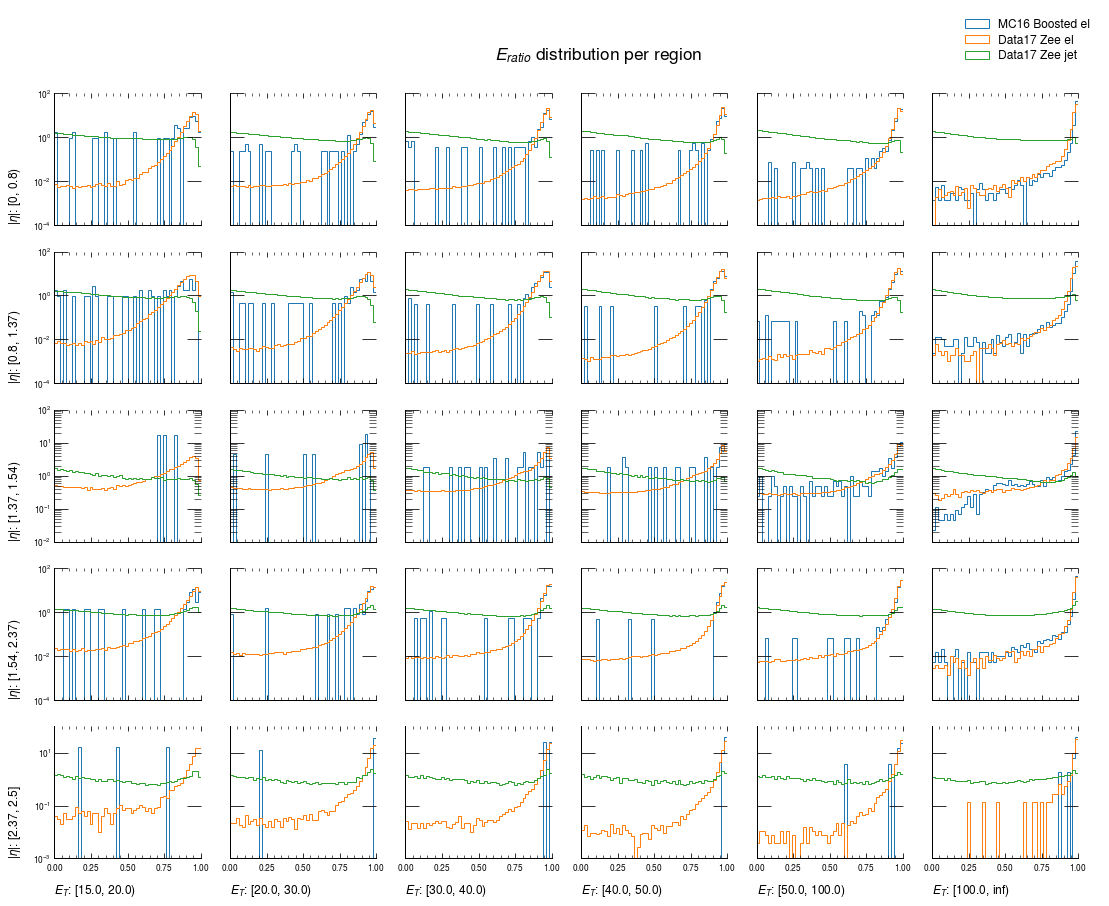

In [31]:
var='eratio'
plot_scale = 'log'
var_info = get_var_info(var)
fig, axes, hists, patches = facetplot(data, x=var_info['l2calo'], col_var='$E_T$', row_var='|$\eta$|', xlabel=var_info['label'], xrange=(0,1), xbins=50, xlim=None, 
                                    col_var_label='$E_T$', row_var_label='|$\eta$|', plot_scale=plot_scale, title=f'{var_info["label"]} distribution per region', 
                                    figsize=(2*9,2*6.6), dpi=72, logger='plot_log', legend_loc=(0.1, 1.10),
                                    col_var_order=boosted_data['$E_T$'].cat.categories, row_var_order=boosted_data['|$\eta$|'].cat.categories)
#fig.tight_layout()

## Joint Plots

Plotting MC16 Boosted el


/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


Plotting Data17 Zee el


/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


Plotting Data17 Zee jet


/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


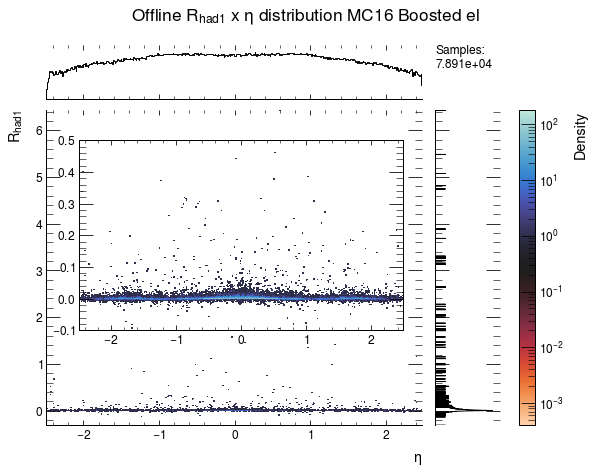

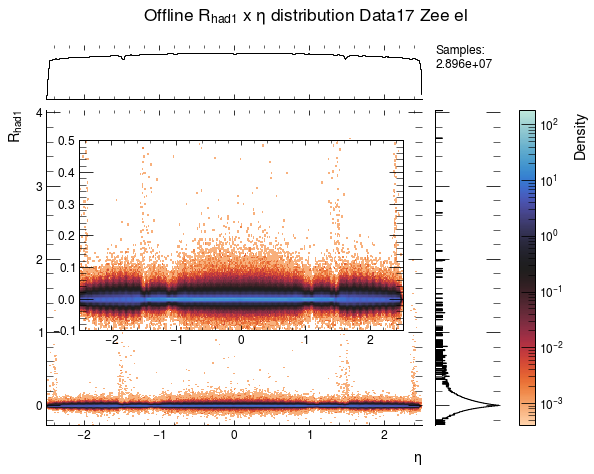

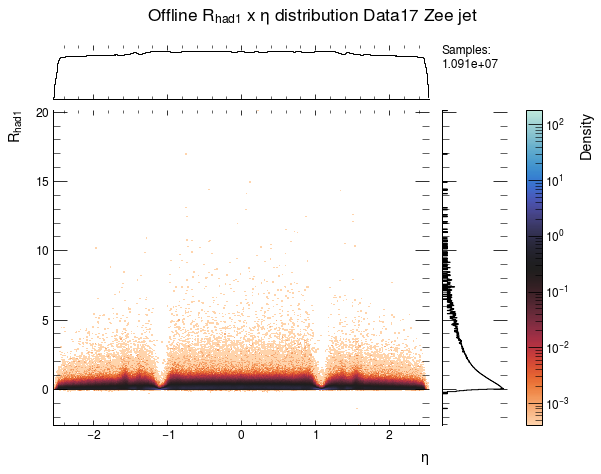

In [19]:
base_ranges = {
    'f3': (0,1),
    'weta2': (0,0.06),
    'reta': (0,1),
    'wstot': (0,200),
    'eratio': (0,98),
    'f1': (0,1),
    'eta': None,
    'et': None,
    'dr': None,
    'mu': (0,100),
    'rphi': (-10, 40),
    'rhad': (-2,30),
    'rhad1': None
}
var_ranges = {key: base_ranges.copy() for key in data.keys()}
var_ranges['MC16 Boosted el']['rphi'] = (0,1)
base_bins = {
    'f3': 1000,
    'weta2': 500,
    'reta': 500,
    'wstot': 1000,
    'eratio': 5000,
    'f1': 1000,
    'eta': 500,
    'et': 500,
    'dr': 500,
    'mu': 100,
    'rphi': 5000,
    'rhad': 1000,
    'rhad1': 1000
}
var_bins = {key: base_bins.copy() for key in data.keys()}
var_bins['MC16 Boosted el']['f1'] = 200
var_bins['MC16 Boosted el']['f3'] = 2000
var_bins['MC16 Boosted el']['wstot'] = 1000
var_bins['MC16 Boosted el']['rhad'] = 5000
var_bins['MC16 Boosted el']['rhad1'] = 5000
sub_axes = {
    'MC16 Boosted el': dict(pos=[0.15, 0.3, 0.5, 0.4],xlim=None,ylim=(-0.1,0.5)),
    'Data17 Zee el': dict(pos=[0.15, 0.3, 0.5, 0.4],xlim=None,ylim=(-0.1,0.5)),
    'Data17 Zee jet': None, #dict(pos=[0.15, 0.3, 0.5, 0.4],xlim=None,ylim=(-0.5,5))
}
x='eta'
y='rhad1'
to_plot = {
    'MC16 Boosted el': True,
    'Data17 Zee el': True and x != 'dr',
    'Data17 Zee jet': True and x != 'dr'
}
joint_plot_dir = os.path.join(output_dir, 'joint_plots')
if not os.path.exists(joint_plot_dir):
    os.makedirs(joint_plot_dir)
plot_scale='log'
x_info = get_var_info(x)
y_info = get_var_info(y)
x_label = x_info['label'] if x!= 'et' else x_info['label'] + ' [GeV]'
y_label = y_info['label'] if y!= 'et' else y_info['label'] + ' [GeV]'
if x != 'dr':
    vmin, vmax = get_hist2d_log_norms(data, x=x, y=y, var_bins=var_bins, var_ranges=var_ranges, step=step)
else:
    vmin=None; vmax=None
for data_name, data_df in data.items():
    if not to_plot[data_name]:
        continue
    print(f'Plotting {data_name}')
    jgrid, info_dict = jointplot(data=data_df, x=x_info[step if x != 'dr' else 'TaP'], y=y_info[step], step=step.capitalize(),
        x_label=x_label, y_label=y_label, data_label=data_name,
        x_bins=var_bins[data_name][x], y_bins=var_bins[data_name][y], x_range=var_ranges[data_name][x], y_range=var_ranges[data_name][y], 
        xlim=None,ylim=None,vmin=vmin, vmax=vmax,
        cmap='icefire_r', norm=plot_scale, figsize=(9,6.6), marginal_ticks=False,
        sub_ax_kwargs=sub_axes[data_name], shared_cmap=True)
    if x == 'et':
        jgrid.ax_joint.axvline(300, color='r', linestyle='--', linewidth=1)
        try:
            info_dict['sub_ax'].axvline(300, color='r', linestyle='--', linewidth=1)
        except KeyError:
            pass
    filename = f'{step}_{x}_{y}_{plot_scale}_scale_{data_name.lower().replace(" ", "_")}_joint_hist.png'
    jgrid.figure.savefig(os.path.join(joint_plot_dir, filename), transparent=False, facecolor='white', dpi=72)

## Wasserstein mapping

In [2]:
from ringer.utils import get_triangle_angle
from ringer.plotting import distance_triangle_plot
from ringer.data import load_var_infos
var_infos = load_var_infos()
wass_distances = pd.read_csv(os.path.join('..', '..', 'data', 'wass_distances.csv'), index_col=0)
wass_distances.head(10)

,name,boosted_el,boosted_jet,el_jet,description
0,reta,0.009634,0.112340,0.106335,fold_0
1,eratio,0.030893,0.570198,0.540972,fold_0
2,f1,0.168429,0.037788,0.131495,fold_0
3,f3,0.005357,0.007369,0.012707,fold_0
4,wstot,0.168632,2.870422,2.806875,fold_0
5,weta2,0.000888,0.004230,0.003354,fold_0
6,rhad,0.007246,0.432240,0.436460,fold_0
7,rhad1,0.005028,0.230405,0.233835,fold_0
8,rphi,0.014843,0.118906,0.107186,fold_0
9,reta,0.009672,0.112294,0.106135,fold_1


$R_{\eta}$ Wasserstein Mapping: -0.016407020427762674
$E_{ratio}$ Wasserstein Mapping: -0.08396968054994502
$f_1$ Wasserstein Mapping: 0.0
$f_3$ Wasserstein Mapping: 0.0
$\omega_{stot}$ Wasserstein Mapping: -0.34227251993294294
$\omega_{\eta 2}$ Wasserstein Mapping: -0.0012093411741681177
$R_{had}$ Wasserstein Mapping: 0.0
$R_{had1}$ Wasserstein Mapping: 0.0
$R_{\phi}$ Wasserstein Mapping: -0.02217220185828523


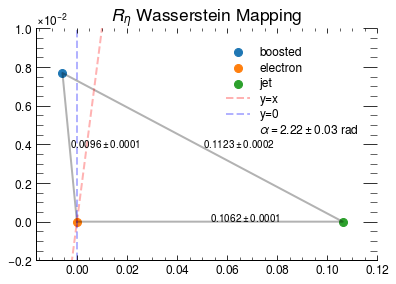

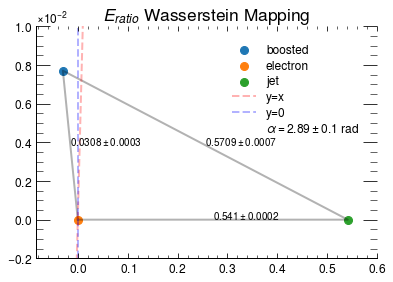

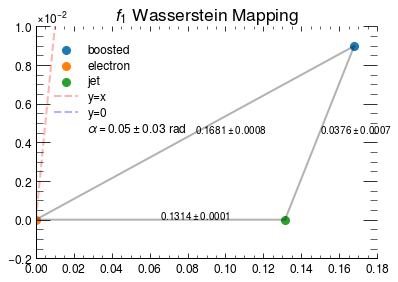

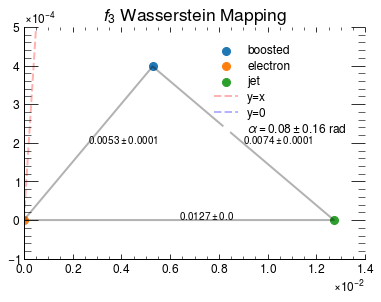

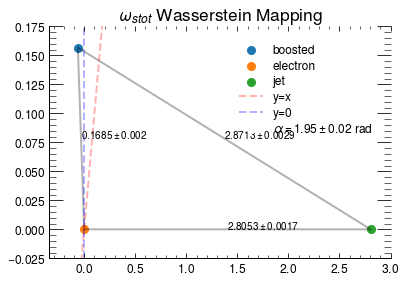

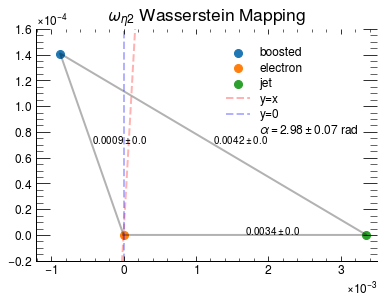

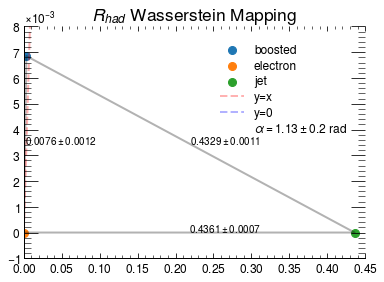

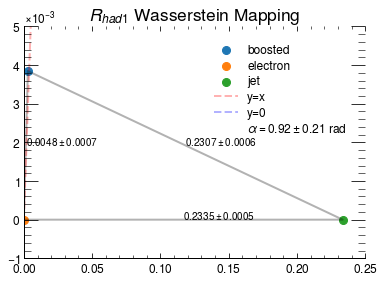

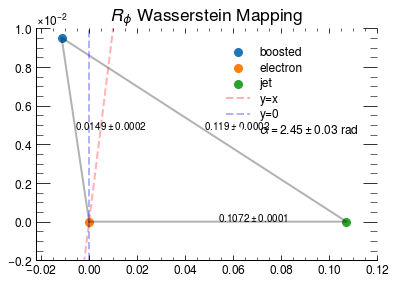

In [3]:
vars_to_plot = wass_distances['name'].unique()
plots = dict()
for var_name in vars_to_plot:
    is_fold_data = wass_distances['description'].str.startswith('fold')
    is_var_data = wass_distances['name'] == var_name
    var_distances = wass_distances.loc[is_fold_data & is_var_data].describe()
    plots[var_name] = distance_triangle_plot(
    a = var_distances.loc['mean', 'boosted_jet'],
    b = var_distances.loc['mean', 'boosted_el'],
    c = var_distances.loc['mean', 'el_jet'],
    a_err = var_distances.loc['std', 'boosted_jet'],
    b_err = var_distances.loc['std', 'boosted_el'],
    c_err = var_distances.loc['std', 'el_jet'],
    A_label = 'electron',
    B_label = 'jet',
    C_label = 'boosted',
    title = f'{var_infos.loc[var_name, "label"]} Wasserstein Mapping',
    plot_references = True,
    legend = True,
    legend_kwargs = {} if var_name != 'f1' else dict(loc=2),
    filepath = os.path.join('analysis', 'wasserstein_mapping', f'{var_name}_fold_mapping.png')
    )

## End

In [48]:
plt.close('all')